# CardioGoodFitness

Статистический анализ данных. Цель выявить типичного пользователя беговой дорожки, а также выяснить отличаются ли пользователи, предпочитающие разные типы беговых дорожек.

## Описание данных 

- Product - тип продукта 
- Age - возраст в годах
- Gender - пол
- Education - образование в годах 
- MaritalStatus - семейный статус 
- Usage - планируют использовать (часы в неделю)
- Fitness - самооценка физической формы по шкале от 1 до 5, где 1 - плохая форма, а 5 - отличная форма. 
- Income - годовой доход
- Miles - планируют пробегать в неделю 

## Подключение библиотек 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plot
import math

## Статистический анализ 

In [2]:
data = pd.read_csv('/datasets/Kaggle/CardioGoodFitness.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product        180 non-null    object
 1   Age            180 non-null    int64 
 2   Gender         180 non-null    object
 3   Education      180 non-null    int64 
 4   MaritalStatus  180 non-null    object
 5   Usage          180 non-null    int64 
 6   Fitness        180 non-null    int64 
 7   Income         180 non-null    int64 
 8   Miles          180 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 12.8+ KB


In [4]:
data.head()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,TM195,18,Male,14,Single,3,4,29562,112
1,TM195,19,Male,15,Single,2,3,31836,75
2,TM195,19,Female,14,Partnered,4,3,30699,66
3,TM195,19,Male,12,Single,3,3,32973,85
4,TM195,20,Male,13,Partnered,4,2,35247,47


### Вывод

Данные не содержат пустых значений 

### Поле Age

In [5]:
def continuous_distribution(data, name, name_ru):
    fig = plot.figure(figsize=(20, 10))
    ax1 = plot.subplot2grid((2, 2), (0, 0))
    sns.histplot(data, x=name, ax=ax1).set(
        title='Гистограмма',
        xlabel=name_ru, 
        ylabel='Количество'
    )

    ax1 = plot.subplot2grid((2, 2), (0, 1))
    sns.histplot(data, x=name,  stat="density", ax=ax1).set(
        title='Плотность распределения',
        xlabel=name_ru, 
        ylabel='Плотность'
    )

    ax1 = plot.subplot2grid((2, 2), (1, 0), colspan=2)

    ax1.xaxis.grid(True)
    sns.boxplot(x=data[name], ax=ax1).set(
        title='Диаграмма размаха',  
        xlabel=name_ru, 
        ylabel=''
    )
    plot.show()

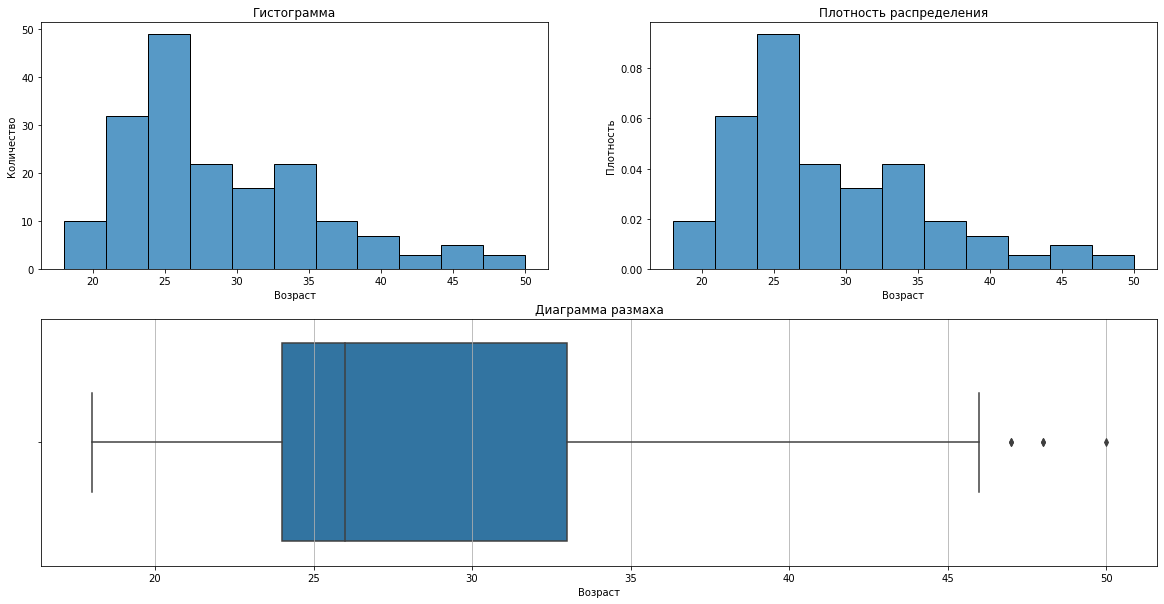

In [6]:
continuous_distribution(data, 'Age', 'Возраст')

Поле содержит небольшое количества выбросов после 45 лет (не многие люди бегают после этого возраста) и предположительно имеет лог-нормальное распределение. Проверим наше предположение.

#### Тестирование поля Age на лог-нормальное распределения 

#### Подготовка данных 

In [7]:
data['Age'].unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 43, 44, 46, 47, 50, 45, 48, 42])

In [8]:
without_outliers = data[data['Age'] < 47]

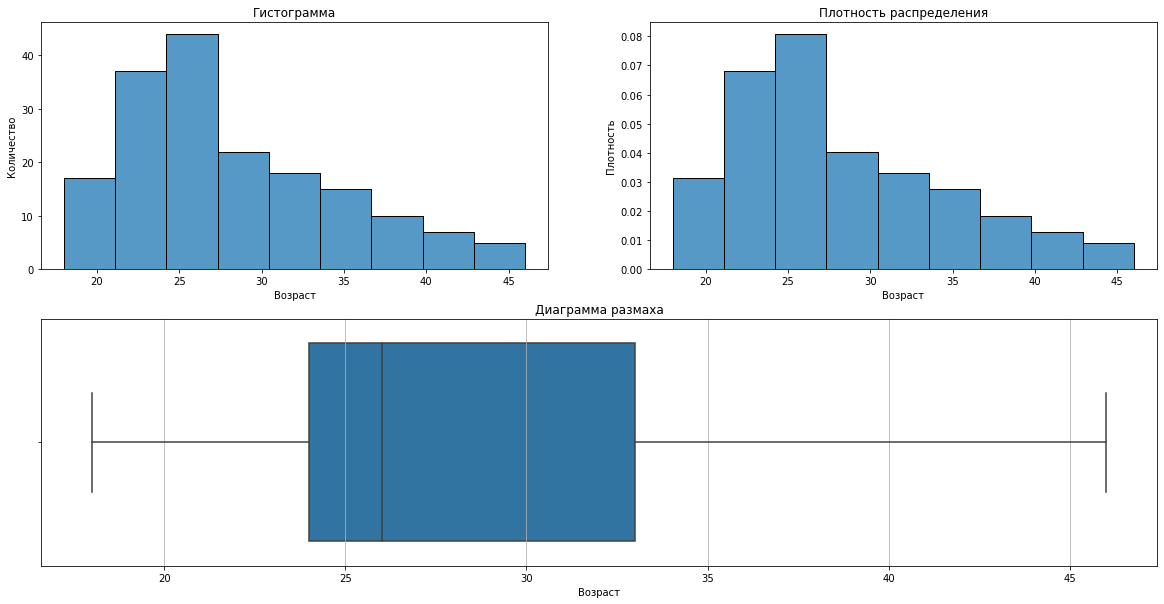

In [9]:
continuous_distribution(without_outliers, 'Age', 'Возраст')

In [10]:
without_outliers['Age'].unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 43, 44, 46, 45, 42])

Данные целочисленные (дискретные), поэтому для проверки гипотезы подойдет хи-квадрат. 

In [11]:
def do_test(p_value, alpha = 0.05):
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Принимаем нулевую гипотезу")

##### Тест хи-квадрат

###### До удаление выбросов 

In [12]:
def do_frequency(values):
    observer_frequency = np.bincount(values)
    
    params = stats.lognorm.fit(values)
    expected_frequency = [len(data) * stats.lognorm.pdf(x, *params) for x in range(values.max() + 1) ]
    expected_frequency = np.array(expected_frequency)
    
    indexes = np.where(expected_frequency == 0)[0]
    observer_frequency = np.delete(observer_frequency, indexes)
    expected_frequency = np.delete(expected_frequency, indexes)
    
    return observer_frequency, expected_frequency

In [13]:
observer_frequency, expected_frequency = do_frequency(data['Age'])

In [14]:
def print_comparing_frequencies(observer_frequency, expected_frequency):
    x = np.arange(len(expected_frequency))  
    width = 0.35 

    fig, ax = plot.subplots(figsize=(15,5))
    ax.bar(x - width/2, observer_frequency, width, label='observer frequency')
    ax.bar(x + width/2, expected_frequency, width, label='expected frequency')

    ax.set_ylabel('Возраст')
    ax.set_title('График сравнения теоретических и наблюдаемых частот ')
    ax.legend()
    
    fig.tight_layout()

    plot.show()

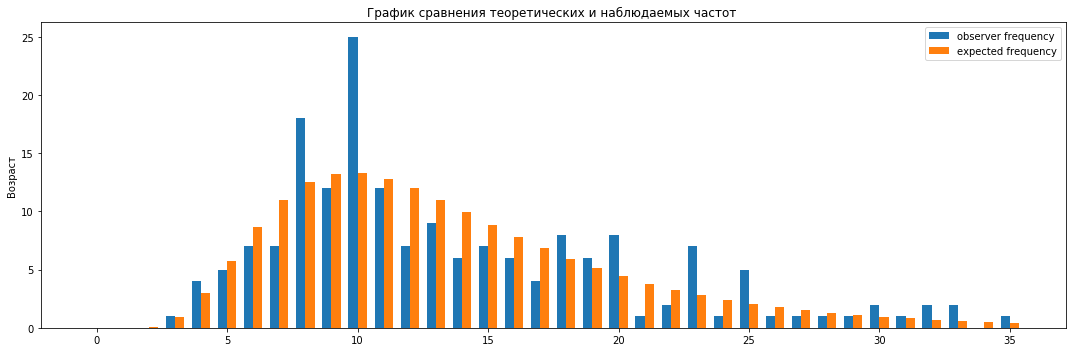

In [15]:
print_comparing_frequencies(observer_frequency, expected_frequency)

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [16]:
result = stats.chisquare(observer_frequency, f_exp=expected_frequency)
result

Power_divergenceResult(statistic=47.79898840803665, pvalue=0.0731463520166491)

In [17]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


###### После удаление выбросов 

In [18]:
observer_frequency, expected_frequency = do_frequency(without_outliers['Age'])

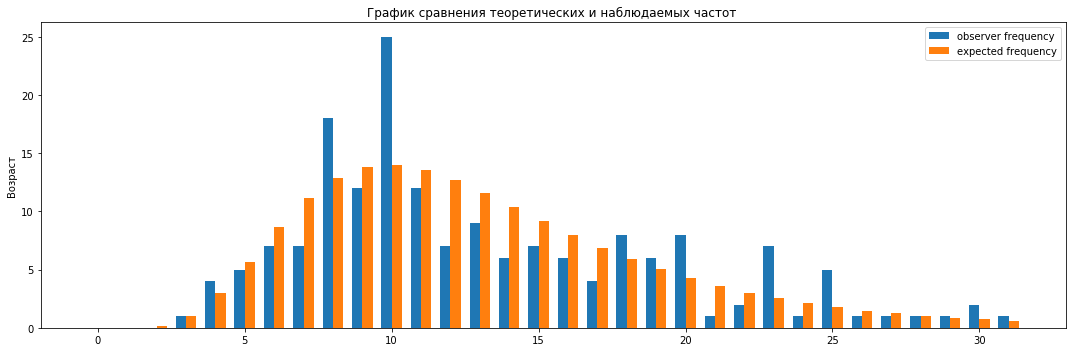

In [19]:
print_comparing_frequencies(observer_frequency, expected_frequency)

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [20]:
result = stats.chisquare(observer_frequency, f_exp=expected_frequency)
result

Power_divergenceResult(statistic=44.475330766195086, pvalue=0.055464544461385844)

In [21]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


##### Тест Колмагорова — Смирнова 

###### До удаление выбросов 

In [22]:
params = stats.lognorm.fit(data['Age'])

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [23]:
result = stats.kstest(data['Age'], stats.lognorm(*params).cdf)

In [24]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


###### После удаление выбросов 

In [25]:
params = stats.lognorm.fit(without_outliers['Age'])

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [26]:
result = stats.kstest(data['Age'], stats.lognorm(*params).cdf)

In [27]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


#### Вывод

Поле Age содержит выбросы (не многие люди бегают после 45 лет) и имеет лог-нормальное распределение. 

### Поле Product  

In [28]:
data['Product'].unique()

array(['TM195', 'TM498', 'TM798'], dtype=object)

In [29]:
def print_categories_variable(colum_name, title, xlabel, ylabel):
    fig = plot.figure(figsize=(20, 5))
    ax1 = plot.subplot2grid((1, 2), (0, 0))
    sns.countplot(x=data[colum_name], ax=ax1).set(
        title=title,  
        xlabel=xlabel, 
        ylabel=ylabel
    )

    ax2 = plot.subplot2grid((1, 2), (0, 1))
    
    colum_name2 = 'Product'
    if colum_name == 'Product':
        colum_name2 = 'Gender'

    tmp = data.groupby(colum_name)[colum_name2].count()
    tmp.plot.pie(autopct="%.1f%%", title=title, ylabel=xlabel, ax=ax2)
    plot.show()

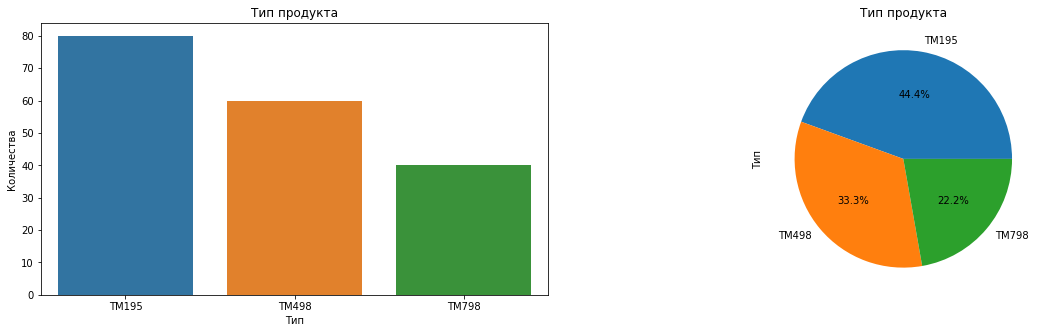

In [30]:
print_categories_variable('Product', 'Тип продукта', 'Тип', 'Количества')

#### Вывод

Пользователи предпочитают беговые дорожки типа TM195

#### Анализ предпочтение пользователей в зависимости от возраста 

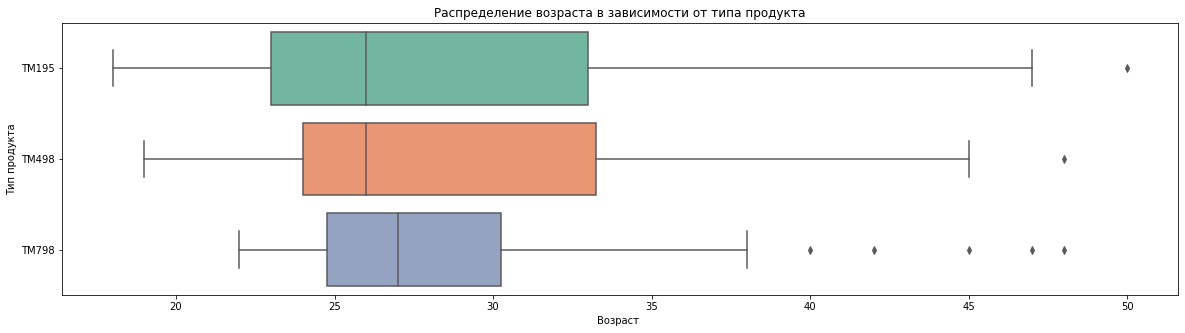

In [31]:
fig = plot.figure(figsize=(20, 5))
sns.boxplot(data=data, x='Age', y='Product', orient="h", palette="Set2").set(
    title='Распределение возраста в зависимости от типа продукта',  
    xlabel='Возраст ', 
    ylabel='Тип продукта'
)
plot.show()

Средний возраст пользователей беговых дорожек типа TM798, выше остальных. Проверим значима ли эти различия.

##### Тест ANOVA

###### До удаление выбросов 

H0 - Средние различаются незначительно

H1 - Различия существенны 

alpha = 0.05

In [32]:
result = stats.f_oneway(data[data['Product'] == 'TM195']['Age'],data[data['Product'] == 'TM498']['Age'],data[data['Product'] == 'TM798']['Age'])

In [33]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


###### После удаление выбросов 

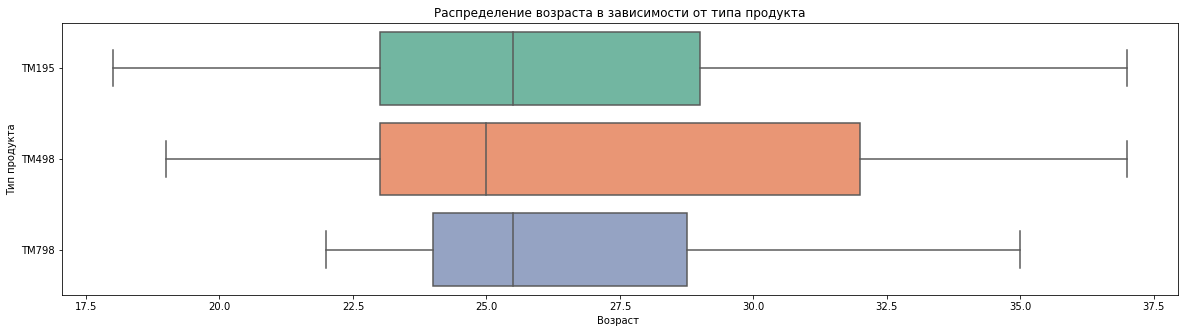

In [34]:
fig = plot.figure(figsize=(20, 5))
tmp = data[data['Age'] < 38]
sns.boxplot(data=tmp, x='Age', y='Product', orient="h", palette="Set2").set(
    title='Распределение возраста в зависимости от типа продукта',  
    xlabel='Возраст ', 
    ylabel='Тип продукта'
)
plot.show()

H0 - Средние различаются незначительно

H1 - Различия существенны 

alpha = 0.05

In [35]:
result = stats.f_oneway(tmp[tmp['Product'] == 'TM195']['Age'], tmp[tmp['Product'] == 'TM498']['Age'], tmp[tmp['Product'] == 'TM798']['Age'])

In [36]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


#### Вывод

Пользователи предпочитают беговые дорожки типа TM195. Возраст не влияет на предпочтения. 

### Поле Gender

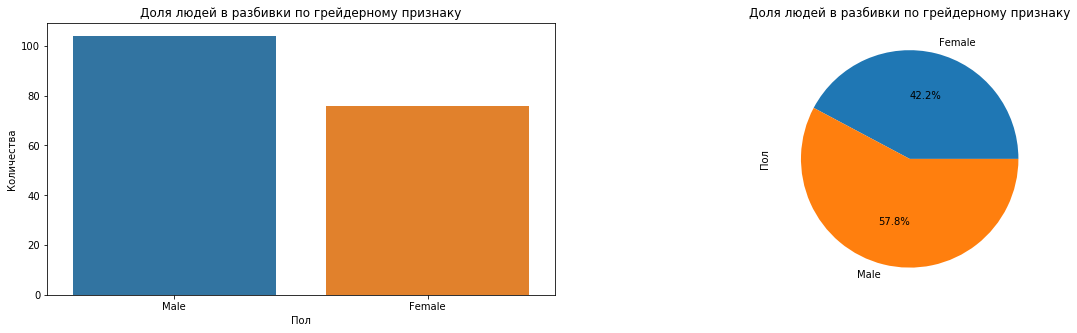

In [37]:
print_categories_variable('Gender', 'Доля людей в разбивки по грейдерному признаку', 'Пол', 'Количества')

use_continuitybool

Среди пользователей беговых дорожек преобладают мужчины

#### Анализ предпочтение пользователей в зависимости от пола

In [38]:
contingency = pd.crosstab(data['Product'], data['Gender'])

In [39]:
contingency

Gender,Female,Male
Product,,
TM195,40,40
TM498,29,31
TM798,7,33


In [40]:
def categorical_compare(contingency, title):
    columns_labels = contingency.columns
    
    rows = len(columns_labels) // 3
    
    columns = 3
    if len(columns_labels) < 3:
        columns = len(columns_labels)     
        rows = 1
        
    fig = plot.figure(figsize=(20, 5 * rows))
    
    for i in range(rows):
        for j in range(columns):
            ax = plot.subplot2grid((rows, columns), (i, j))
            contingency[columns_labels[i*columns + j]].plot.pie(autopct="%.1f%%", title=title, ylabel=columns_labels[i*columns + j], ax=ax)

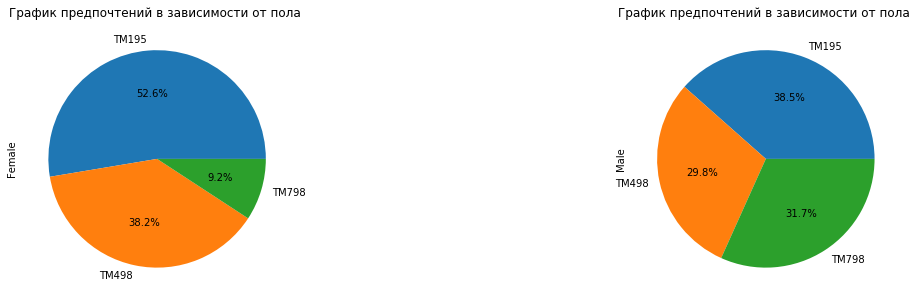

In [41]:
 categorical_compare(contingency, 'График предпочтений в зависимости от пола ')

Спрос на беговые дорожки у мужчин имеет следующие распределение 
- ТМ498 - 29.8 %
- ТМ798 - 31.7 %
- ТМ195 - 38.5 %

Спрос на беговые дорожки у женщин имеет следующие распределение
- ТМ798 - 9.2 %
- ТМ498 - 38.2 %
- ТМ195 - 52.6 %

Проверим значимость этих различий 

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [42]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [43]:
do_test(p)

Отвергаем нулевую гипотезу


##### Вывод

Предпочтение мужчин и женщин действительно различны 

#### Анализ возраста пользователей беговых дорожек в разбивки по грейдерному признаку 

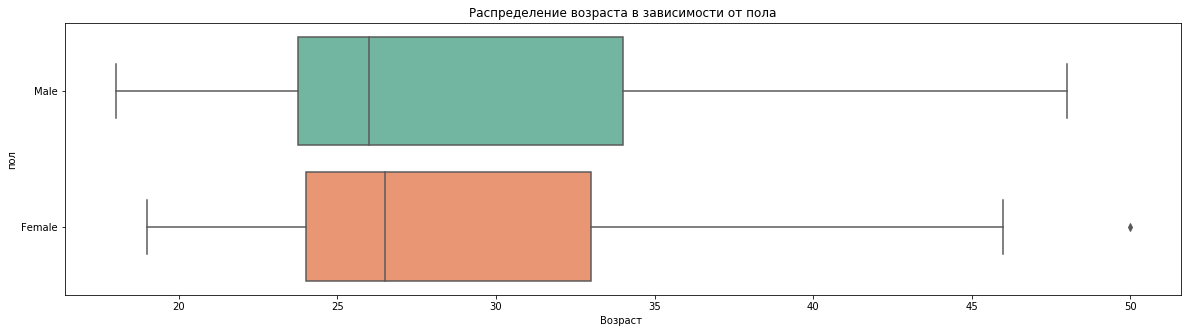

In [44]:
fig = plot.figure(figsize=(20, 5))
sns.boxplot(data=data, x='Age', y='Gender', orient="h", palette="Set2").set(
    title='Распределение возраста в зависимости от пола',  
    xlabel='Возраст ', 
    ylabel='пол'
)
plot.show()

Видно, что средние отличаются несущественно, проверим значимость этих различий (так, как данные содержат выбросы воспользуемся тестом Манна - Уитни)

H0 - Средние идентичны

H1 - Различия существенны 

alpha = 0.05

In [45]:
result = stats.mannwhitneyu(data[data['Gender'] == 'Male']['Age'], data[data['Gender'] == 'Female']['Age'])

In [46]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


#### Вывод

Средний возраст мужнин и женщин, использующих беговую дорожку, идентичен./

### Поле Education

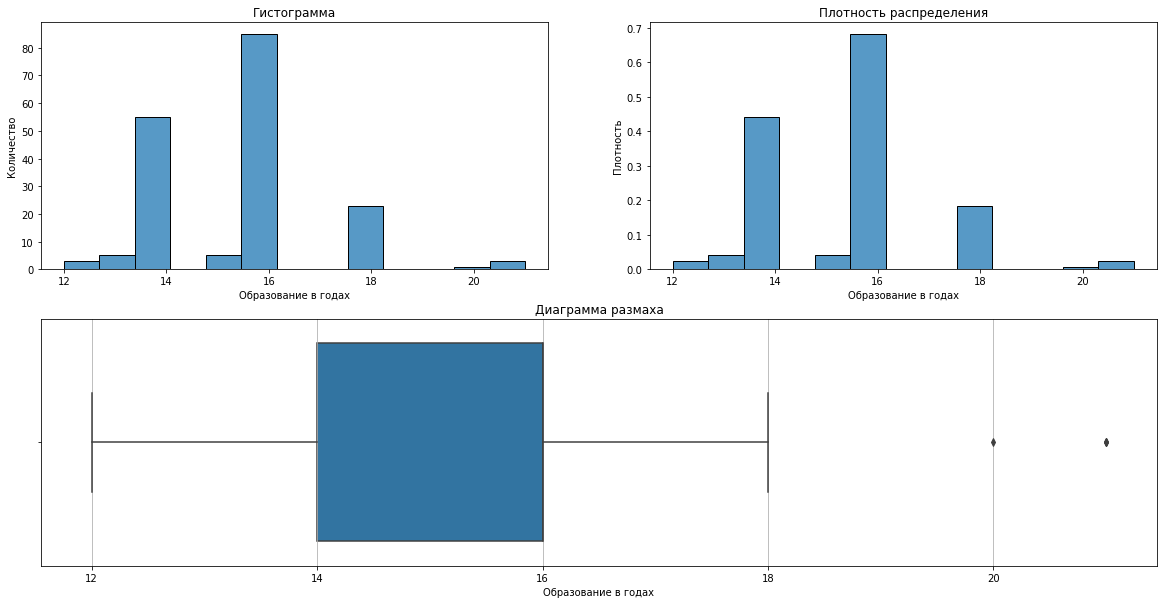

In [47]:
continuous_distribution(data, 'Education', 'Образование в годах')

Образование имеет дискретный график, так как на освоение определенной профессии требуется фиксированное количество лет. Нельзя сказать, что люди с 16 летним образованием, чаще остальных занимаются бегом, возможно таких людей просто больше. 

#### Анализ влияние образования на выбор типа продукта 

In [48]:
len(data[data['Education'] > 18])

4

Так как вопросов немного, просто удалим их 

In [49]:
tmp = data[data['Education'] < 19]

In [50]:
tmp['Education'].unique()

array([14, 15, 12, 13, 16, 18])

Поле содержит только несколько значений, непонятно к какому типу его отнести, поэтому будем проверять гипотезы считая его как категориальной, так и непрерывной переменной.  

#### Анализ в предположении, что Education - категориальная переменная 

In [51]:
contingency = pd.crosstab(tmp['Education'], tmp['Product'])

In [52]:
contingency

Product,TM195,TM498,TM798
Education,,,
12,2,1,0
13,3,2,0
14,30,23,2
15,4,1,0
16,39,31,15
18,2,2,19


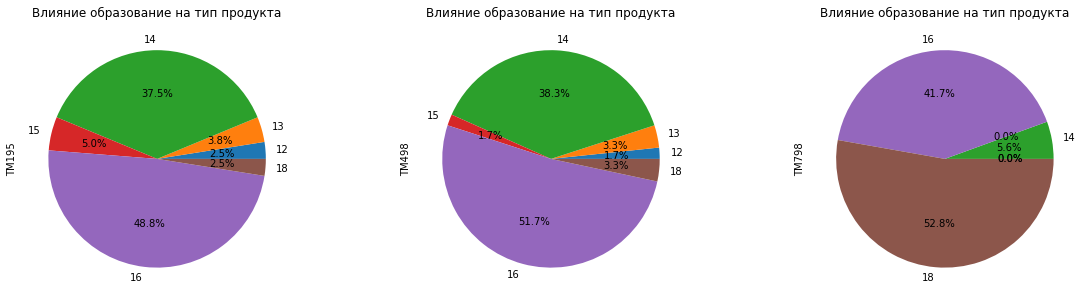

In [53]:
categorical_compare(contingency, 'Влияние образование на тип продукта')

In [54]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [55]:
do_test(p)

Отвергаем нулевую гипотезу


##### Вывод

Видно, что уровень образования влияет на выбор продукта 

#### Анализ в предположении, что Education - непрерывная переменная 

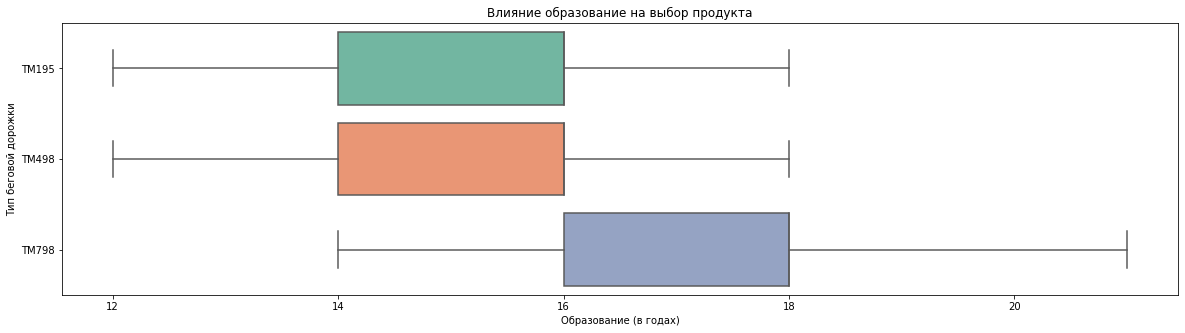

In [56]:
plot.figure(figsize=(20, 5))

tmp = data
tmp['Education'] = data['Education'].astype('float')

sns.boxplot(data=tmp, x='Education', y='Product', orient="h", palette="Set2").set(
    title='Влияние образование на выбор продукта',  
    xlabel='Образование (в годах)', 
    ylabel='Тип беговой дорожки'
)

plot.show()

In [57]:
result = stats.f_oneway(tmp[tmp['Product'] == 'TM195']['Education'], tmp[tmp['Product'] == 'TM498']['Education'], tmp[tmp['Product'] == 'TM798']['Education'])

In [58]:
do_test(result.pvalue)

Отвергаем нулевую гипотезу


##### Вывод

Видно, что уровень образования влияет на выбор продукта 

#### Анализ влияние образования на возраст 

In [59]:
data['Age'].unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 43, 44, 46, 47, 50, 45, 48, 42])

In [60]:
data['Education'].unique()

array([14., 15., 12., 13., 16., 18., 20., 21.])

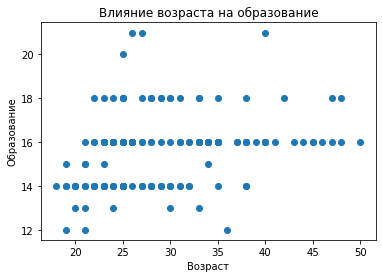

In [61]:
plot.scatter(data['Age'], data['Education'])
plot.title("Влияние возраста на образование")
plot.xlabel("Возраст")
plot.ylabel("Образование")
plot.show()

Линейной зависимости между возрастом и уровнем образованию не наблюдается 

In [62]:
coef, p = stats.spearmanr(data['Age'], data['Education'])

In [63]:
coef

0.3327693831510358

In [64]:
do_test(p)

Отвергаем нулевую гипотезу


По шкале Чеддока признаки имеют слабую положительную связь и эта связь значительна 

#### Анализ влияние образования на пол

In [65]:
data.head()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,TM195,18,Male,14.0,Single,3,4,29562,112
1,TM195,19,Male,15.0,Single,2,3,31836,75
2,TM195,19,Female,14.0,Partnered,4,3,30699,66
3,TM195,19,Male,12.0,Single,3,3,32973,85
4,TM195,20,Male,13.0,Partnered,4,2,35247,47


In [66]:
tmp = data[data['Education'] < 19]

#### Анализ в предположении, что Education - категориальная переменная 

In [67]:
contingency = pd.crosstab(tmp['Education'], tmp['Gender'])

In [68]:
contingency

Gender,Female,Male
Education,,
12.0,0,3
13.0,1,4
14.0,30,25
15.0,2,3
16.0,35,50
18.0,7,16


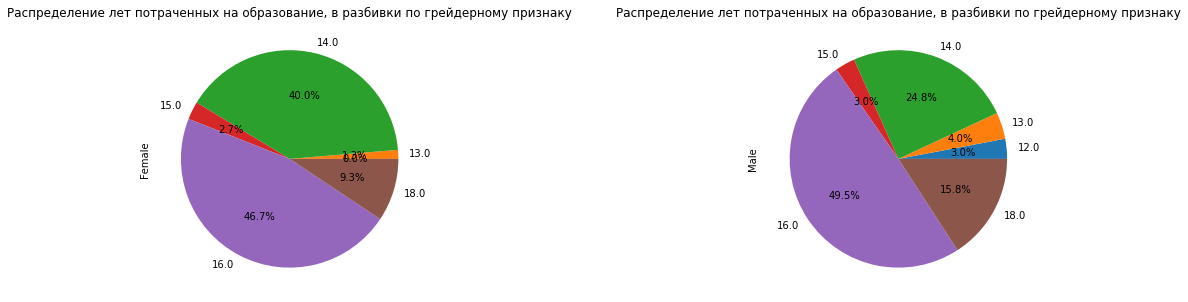

In [69]:
categorical_compare(contingency, 'Распределение лет потраченных на образование, в разбивки по грейдерному признаку')

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [70]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [71]:
do_test(p)

Принимаем нулевую гипотезу


##### Вывод

Уровень образования не зависит от пола 

#### Анализ в предположении, что Education - непрерывная переменная 

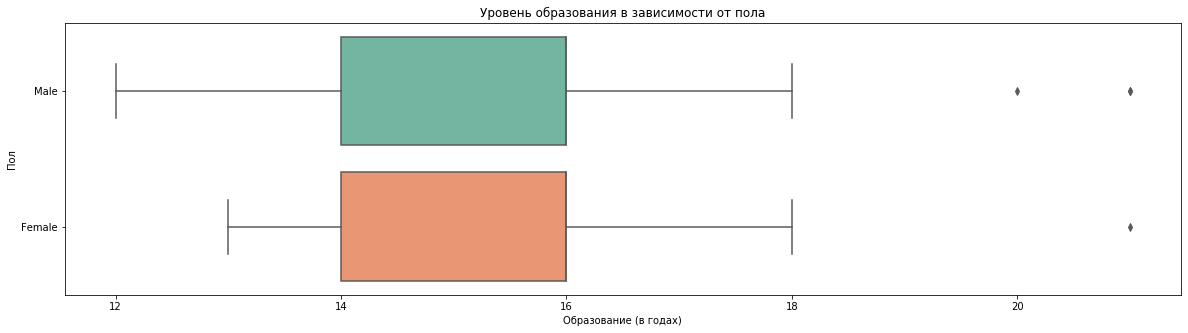

In [72]:
plot.figure(figsize=(20, 5))

tmp = data
tmp['Education'] = data['Education'].astype('float')

sns.boxplot(data=tmp, x='Education', y='Gender', orient="h", palette="Set2").set(
    title='Уровень образования в зависимости от пола',  
    xlabel='Образование (в годах)', 
    ylabel='Пол'
)

plot.show()

H0 - Средние идентичны

H1 - Различия существенны 

alpha = 0.05

In [73]:
result = stats.ttest_ind(data[data['Gender'] == 'Male']['Education'], data[data['Gender'] == 'Female']['Education'])

In [74]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


##### Вывод

Уровень образования не зависит от пола 

### Поле MaritalStatus

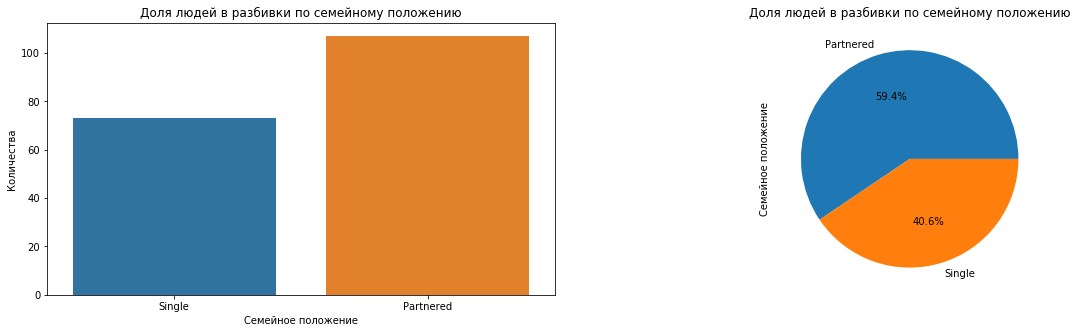

In [75]:
print_categories_variable('MaritalStatus', 'Доля людей в разбивки по семейному положению', 'Семейное положение', 'Количества')

Люди в браке чаще предпочитают бег 

#### Анализ влияние семейного положения на выбор типа продукта 